# ARIMA for EPS (Earnings per share) Johnson & Johnson

Importing libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
#Import Data

data = pd.read_csv('jj.csv')

data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


Let's see how the EPS looks like as a function of time

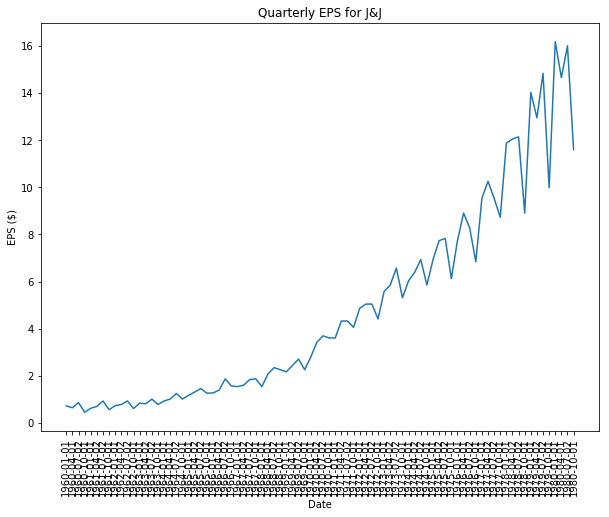

In [4]:

plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.show()

It can be seen that there is an increasing trend with time, showing that the time-series is not stationary

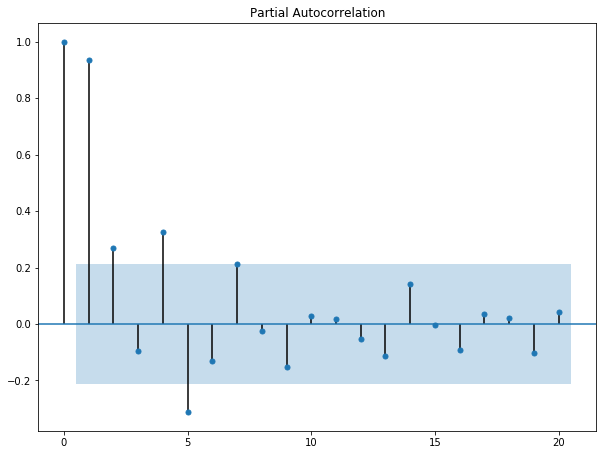

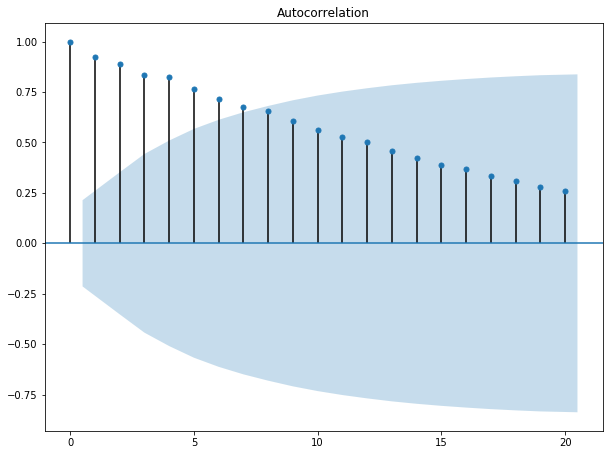

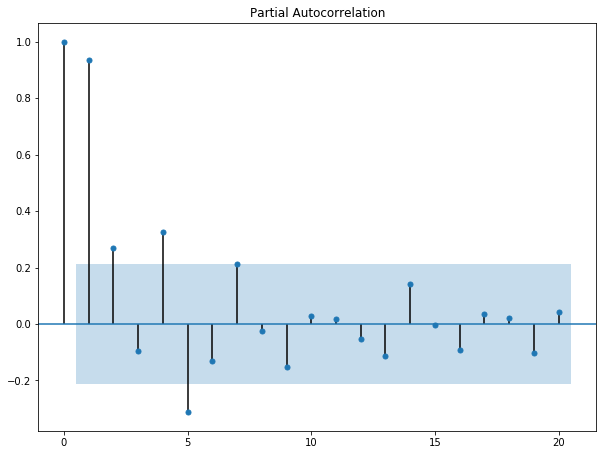

In [6]:
plot_acf(data['data'])
plot_pacf(data['data'])

Since both ACF and PACF are sinusoidal, the time series is not stationary. To make it stationary and fit a model to make predictions, we will apply the log-difference transformation to the data-set. 

In [8]:

data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


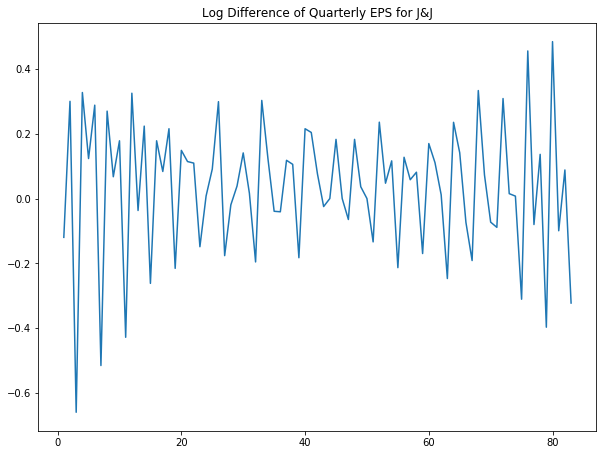

In [9]:
plt.plot(data['data_tr_1'])
plt.title('Log Difference of Quarterly EPS for J&J')
plt.show()

After applying the log-transformation it can be seen that the data has become stationary. But just to make sure that we actually have a stationary time series, we will perform the Augmented Dicky Fuller test.

In [10]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')

print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811827
p-value: 0.0004149731404440818


Since the p-value is less than 0.05, we can reject the null-hypothesis and establish that the time-series is stationary and we can start fitting our model. 

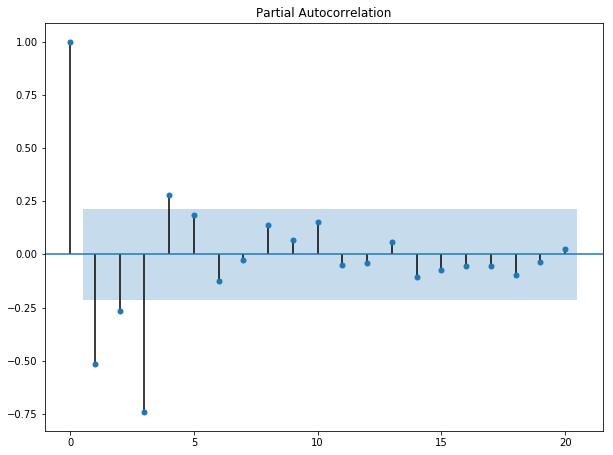

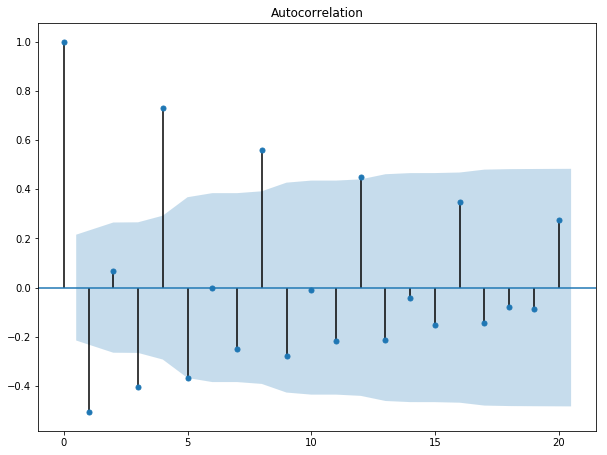

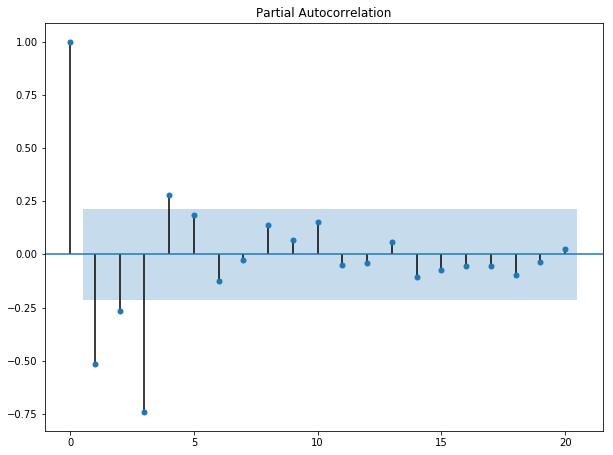

In [11]:
plot_acf(data['data_tr_1'][1:])
plot_pacf(data['data_tr_1'][1:])

Since the ACF and PACF are still decaying/sinosoidal, the models are neither Moving-Average nor Autoregressive models. Let's assume the model is the ARIMA model with a differencing value d = 1 

The next task is to estimate the p and q parameters. 

For this,  we will be writing an optimization function which will fit the entire dataset from a range of p & q combination values. It will then calculate AIC for each legitimate combination value. From that we will be selecting the most optimum p,q combination

In [15]:

def optimize_ARIMA(endog, order_list):
    """
    Returns a dataframe with parameters and corresponding AIC

    order_list - list with (p,d,q) tuples
    endog - the observed variable (Quarterly Earnings per Share)

    """

    results = []

    for order in tqdm_notebook(order_list):  #Tqdm- Progression bar in Jupyter Notebook
        try: 
            model = SARIMAX(endog, order = order, simple_differencing = False).fit(disp = False)

        except: 
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return result_df 

Now, we will generate the parameters that have to be passed to the optimization function

In [16]:
ps = range(0, 8, 1)
qs = range(0, 8 ,1)
d = 1
parameters = product(ps,qs) #Cartesian Product

parameters_list = list(parameters)

order_list = []

for each in parameters_list:

    each = list(each)
    each.insert(1, d) #Insert 1 in the middle (1st index as d= 1)
    each = tuple(each)
    order_list.append(each)

order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

Let's run the optimization

In [17]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.513578
1,"(4, 1, 6)",115.859202
2,"(7, 1, 1)",116.051259
3,"(5, 1, 3)",116.536190
4,"(5, 1, 4)",117.242545
5,"(5, 1, 2)",117.326370
6,"(6, 1, 2)",117.612718
7,"(5, 1, 6)",117.743196
8,"(4, 1, 7)",117.782133
9,"(7, 1, 2)",117.823981


Based on AIC, (p,d,q) = (6,1,3)


We will now fit the model based on these optimum parameters

In [19]:
#Remodel:
best_model = SARIMAX(data['data'], order = (6,1,3), simple_differencing = False)
res = best_model.fit(disp = False)

In [21]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.757
Date:                Mon, 20 Sep 2021   AIC                            115.514
Time:                        11:24:40   BIC                            139.702
Sample:                             0   HQIC                           125.231
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4855      0.132    -11.253      0.000      -1.744      -1.227
ar.L2         -0.7803      0.152     -5.140      0.000      -1.078      -0.483
ar.L3          0.0401      0.063      0.635      0.5

Let us make some diagnostic curves to see the performance of the fitted model

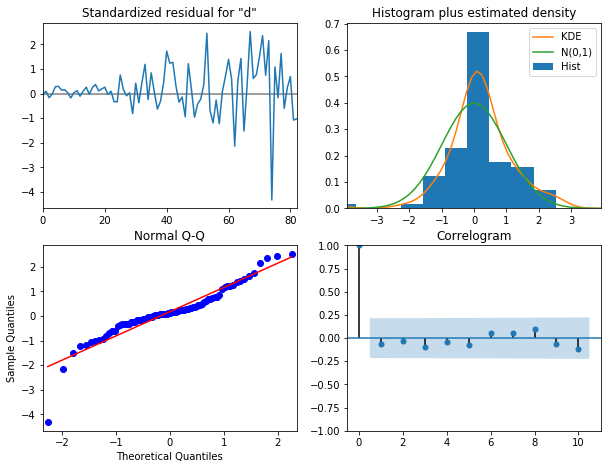

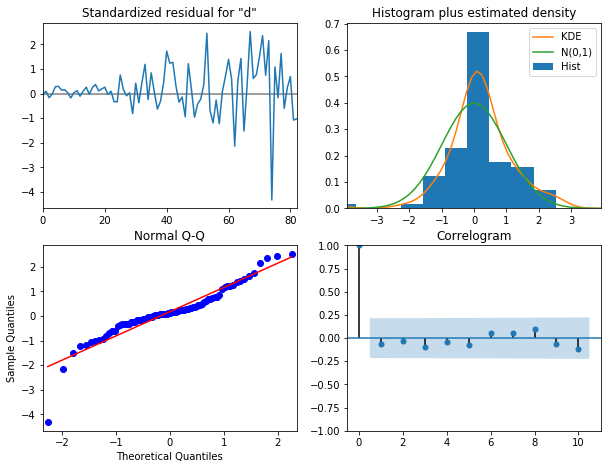

In [23]:
res.plot_diagnostics()

The residual diagnostics look pretty good. The residuals are normally distributed, which can be seen from the distribution and quartile-quartile curves.

We will now be predicting the ESP's for the next 8 quarters. 

[Text(0.5, 1.0, 'Forecast of Quarterly EPS for J&J')]

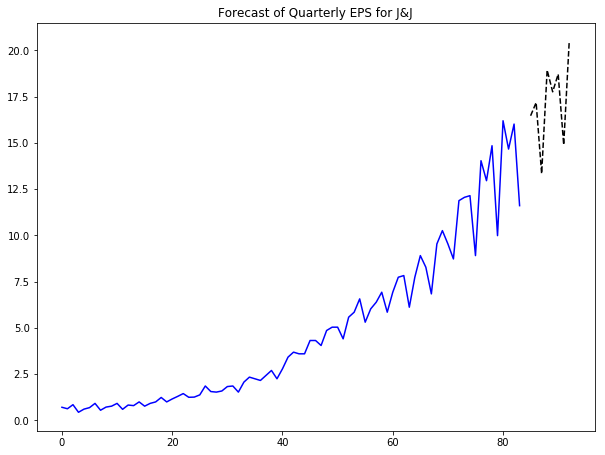

In [25]:
n_forecast = 8 #Predicting next two years (8 quarters)

predict = res.get_prediction(end = best_model.nobs + n_forecast)

idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()

ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of Quarterly EPS for J&J')

The black-line depicts the predictions of 8 quarters after the observations (depicted in blue)

In [26]:
data['model'] = predict.predicted_mean

data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.675862
3,1960-10-01,0.44,-0.658462,0.732897
4,1961-01-01,0.61,0.326684,0.637496
5,1961-04-02,0.69,0.123233,0.527484
6,1961-07-02,0.92,0.287682,0.786772
7,1961-10-01,0.55,-0.514455,0.486783
8,1962-01-01,0.72,0.269333,0.652890
9,1962-04-02,0.77,0.067139,0.753067


In [28]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE: {mse}')

MSE: 0.16027644752543013


The mean-squared error is 0.16, which is pretty low. This proves that our ARIMA model is highly accurate.